### Q3

Training DataFrame:
                                          X (Sketch)  \
0  [[103, 101, 76, 43, 34, 51, 56, 81, 90, 114, 1...   
1  [[232, 253, 254, 253, 250, 248, 246, 246, 247,...   
2  [[243, 252, 255, 255, 254, 253, 251, 251, 249,...   
3  [[222, 254, 251, 251, 250, 252, 250, 250, 249,...   
4  [[226, 250, 255, 254, 248, 244, 238, 238, 238,...   

                                      Y (Real Image)  
0  [[240, 240, 240, 241, 216, 192, 200, 220, 201,...  
1  [[182, 188, 183, 184, 185, 185, 186, 186, 187,...  
2  [[148, 151, 153, 155, 157, 158, 159, 160, 162,...  
3  [[218, 218, 218, 211, 199, 179, 172, 164, 172,...  
4  [[188, 194, 198, 202, 209, 212, 214, 220, 224,...  

Testing DataFrame:
                                          X (Sketch)  \
0  [[250, 250, 254, 254, 255, 254, 254, 254, 254,...   
1  [[231, 254, 254, 255, 251, 249, 248, 248, 248,...   
2  [[189, 246, 245, 245, 238, 232, 229, 233, 233,...   
3  [[244, 252, 255, 254, 252, 249, 248, 248, 247,...   
4  [[229, 253

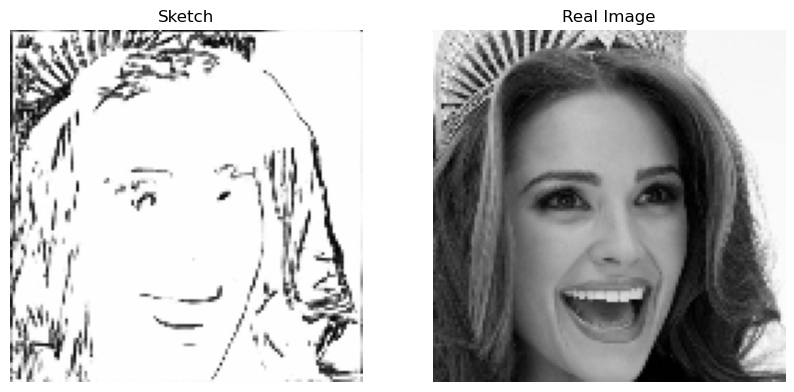

In [2]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# Define the base directory for your dataset
base_dir = 'Q3_archive'

# Define the desired image size for resizing
width, height = 128, 128  # Modify as needed

# Initialize lists to hold the data
train_data = []
test_data = []
val_data = []

# Define the folder names for train, test, and val
folders = ['train', 'test', 'val']

# Iterate through each folder to gather image paths
for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    
    # Gather paths for sketches and real images
    sketches_path = os.path.join(folder_path, 'sketches')
    images_path = os.path.join(folder_path, 'photos')
    
    # Collect paths for sketches and corresponding real images
    for sketch in os.listdir(sketches_path):
        if sketch.endswith(('.png', '.jpg', '.jpeg')):  # Modify the extensions as necessary
            sketch_path = os.path.join(sketches_path, sketch)
            real_image_path = os.path.join(images_path, sketch)
            if os.path.exists(real_image_path):
                # Load images in grayscale using OpenCV
                sketch_image = cv2.imread(sketch_path, cv2.IMREAD_GRAYSCALE)
                real_image = cv2.imread(real_image_path, cv2.IMREAD_GRAYSCALE)
                
                # Resize images
                sketch_image = cv2.resize(sketch_image, (width, height))
                real_image = cv2.resize(real_image, (width, height))
                
                # Append to the respective dataset lists
                if folder == 'train':
                    train_data.append((sketch_image, real_image))
                elif folder == 'test':
                    test_data.append((sketch_image, real_image))
                elif folder == 'val':
                    val_data.append((sketch_image, real_image))

# Create DataFrames for each dataset
train_df = pd.DataFrame(train_data, columns=['X (Sketch)', 'Y (Real Image)'])
test_df = pd.DataFrame(test_data, columns=['X (Sketch)', 'Y (Real Image)'])
val_df = pd.DataFrame(val_data, columns=['X (Sketch)', 'Y (Real Image)'])

# Display the DataFrames
print("Training DataFrame:")
print(train_df.head())

print("\nTesting DataFrame:")
print(test_df.head())

print("\nValidation DataFrame:")
print(val_df.head())

# Function to display grayscale images using Matplotlib
def display_images(sketch, real_image):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(sketch, cmap='gray')  # Use gray colormap for grayscale
    plt.title('Sketch')
    plt.axis('off')  # Turn off axis

    plt.subplot(1, 2, 2)
    plt.imshow(real_image, cmap='gray')  # Use gray colormap for grayscale
    plt.title('Real Image')
    plt.axis('off')  # Turn off axis
    
    plt.show()

# Example: Display the first images using Matplotlib
display_images(train_df.iloc[0]['X (Sketch)'], train_df.iloc[0]['Y (Real Image)'])


In [3]:
train_df.to_pickle("Sketch_train.pkl")
test_df.to_pickle("Sketch_test.pkl")
val_df.to_pickle("Sketch_val.pkl")

In [1]:
import pandas as pd
train_df = pd.read_pickle("Sketch_train.pkl")
test_df = pd.read_pickle("Sketch_test.pkl")
val_df = pd.read_pickle("Sketch_val.pkl")

### Creating Tensors

In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Function to convert DataFrame to TensorDataset
def df_to_tensor(df):
    # Extract sketches and real images as numpy arrays and normalize
    sketches = np.stack(df['X (Sketch)'].values) / 255.0
    real_images = np.stack(df['Y (Real Image)'].values) / 255.0
    
    # Convert to PyTorch tensors
    sketches_tensor = torch.tensor(sketches, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
    real_images_tensor = torch.tensor(real_images, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
    
    # Return as a TensorDataset
    return TensorDataset(sketches_tensor, real_images_tensor)

# Convert the DataFrames to TensorDatasets
train_dataset = df_to_tensor(train_df)
test_dataset = df_to_tensor(test_df)
val_dataset = df_to_tensor(val_df)

# Define DataLoader for batching
batch_size = 64  # Set batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [3]:
import torch.nn as nn

# Define the Generator
class Generator(nn.Module):
    def __init__(self, input_channels=1, output_channels=1):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64, output_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output range between -1 and 1
        )
    
    def forward(self, x):
        return self.main(x)

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_channels=2):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # Add a fully connected layer to output a single value for each image in the batch
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 8 * 8, 1),  # Adjust 8*8 if necessary based on your image size
            nn.Sigmoid()
        )

    def forward(self, x, sketch):
        x = torch.cat([x, sketch], dim=1)  # Concatenate sketch and real/fake image
        x = self.main(x)
        return self.fc(x)



Epoch [1/30], Step [100/323], D Loss: 0.0118, G Loss: 7.3454
Epoch [1/30], Step [200/323], D Loss: 0.0682, G Loss: 5.2046
Epoch [1/30], Step [300/323], D Loss: 0.2598, G Loss: 4.9480
Epoch [2/30], Step [100/323], D Loss: 0.0549, G Loss: 5.3925
Epoch [2/30], Step [200/323], D Loss: 0.1108, G Loss: 4.8887
Epoch [2/30], Step [300/323], D Loss: 0.0344, G Loss: 7.4349
Epoch [3/30], Step [100/323], D Loss: 0.0195, G Loss: 7.2262
Epoch [3/30], Step [200/323], D Loss: 0.2608, G Loss: 3.7625
Epoch [3/30], Step [300/323], D Loss: 0.0236, G Loss: 6.2091
Epoch [4/30], Step [100/323], D Loss: 0.1332, G Loss: 4.2669
Epoch [4/30], Step [200/323], D Loss: 0.0287, G Loss: 6.9891
Epoch [4/30], Step [300/323], D Loss: 0.0183, G Loss: 6.3977
Epoch [5/30], Step [100/323], D Loss: 0.0065, G Loss: 7.4118
Epoch [5/30], Step [200/323], D Loss: 0.0399, G Loss: 6.5614
Epoch [5/30], Step [300/323], D Loss: 0.0043, G Loss: 7.4809
Epoch [6/30], Step [100/323], D Loss: 0.0821, G Loss: 5.7329
Epoch [6/30], Step [200/

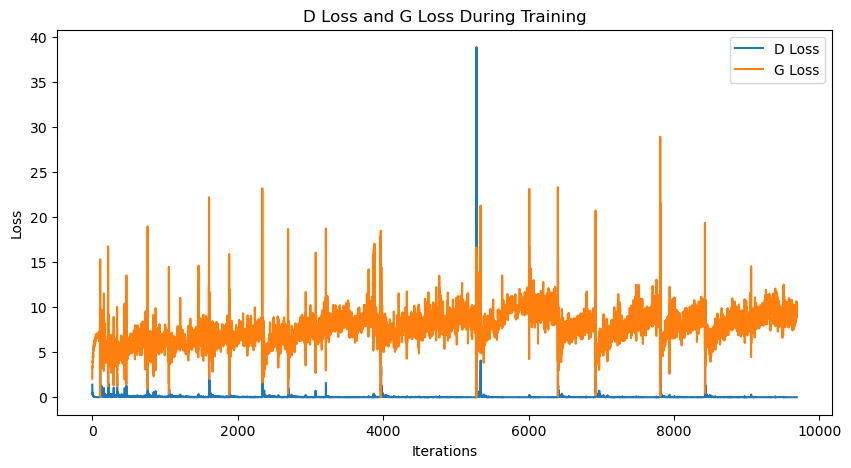

In [4]:
import matplotlib.pyplot as plt

# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Define loss function and optimizers
criterion = nn.BCELoss()
optimizer_g = torch.optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

# Lists to store loss values
d_losses = []
g_losses = []

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    for i, (sketches, real_images) in enumerate(train_loader):
        sketches, real_images = sketches.to(device), real_images.to(device)

        # Train Discriminator
        optimizer_d.zero_grad()
        real_labels = torch.ones((real_images.size(0), 1), device=device)
        fake_labels = torch.zeros((real_images.size(0), 1), device=device)
        
        outputs = discriminator(real_images, sketches)
        outputs = outputs.view(-1, 1)  # Flatten to match the shape of real_labels
        d_loss_real = criterion(outputs, real_labels)
        
        fake_images = generator(sketches)
        outputs = discriminator(fake_images.detach(), sketches)
        outputs = outputs.view(-1, 1)  # Flatten to match the shape of fake_labels
        d_loss_fake = criterion(outputs, fake_labels)
        
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_d.step()
        
        # Train Generator
        optimizer_g.zero_grad()
        outputs = discriminator(fake_images, sketches)
        outputs = outputs.view(-1, 1)  # Flatten to match the shape of real_labels
        g_loss = criterion(outputs, real_labels)
        
        g_loss.backward()
        optimizer_g.step()

        # Save loss values
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        # Logging
        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

# Plot D Loss and G Loss
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='D Loss')
plt.plot(g_losses, label='G Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('D Loss and G Loss During Training')
plt.legend()
plt.show()


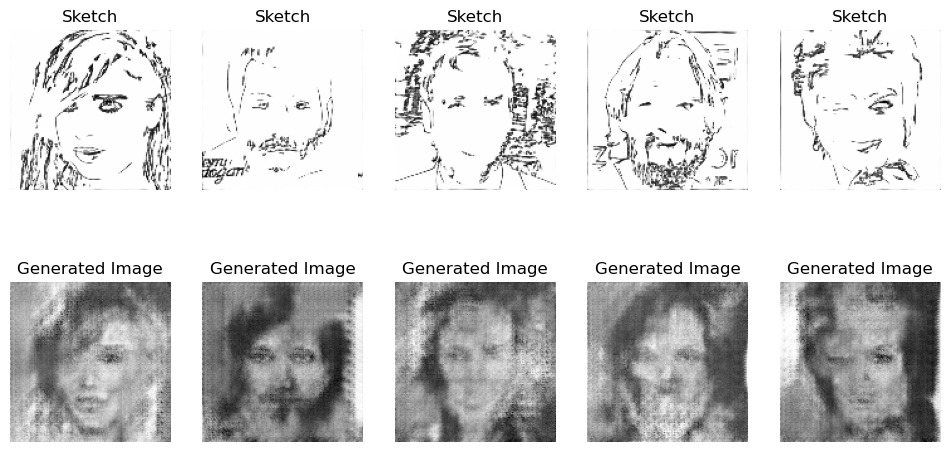

In [10]:
import matplotlib.pyplot as plt

# Function to display results
def display_results(sketches, generated_images, num_samples=5):
    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        # Display sketch
        plt.subplot(2, num_samples, i+1)
        plt.imshow(sketches[i].cpu().squeeze(), cmap='gray')
        plt.title("Sketch")
        plt.axis('off')
        
        # Display generated image
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(generated_images[i].cpu().squeeze(), cmap='gray')
        plt.title("Generated Image")
        plt.axis('off')
    plt.show()

# Set model to evaluation mode
generator.eval()

# Disable gradient calculations for validation to save memory and computation
with torch.no_grad():
    for i, (sketches, _) in enumerate(val_loader):
        sketches = sketches.to(device)

        # Generate images
        generated_images = generator(sketches)
        
        # Display the first batch of results
        display_results(sketches, generated_images, num_samples=5)
        break  # Display only one batch


In [6]:
# Specify the path where you want to save the models on Google Drive
generator_save_path = 'generator3.pth'
discriminator_save_path = 'discriminator3.pth'

# Save the generator and discriminator models
torch.save(generator.state_dict(), generator_save_path)
torch.save(discriminator.state_dict(), discriminator_save_path)

print("Models saved successfully!")


Models saved successfully!
